## Analyzing language across Feminist and Men's Rights subreddits

In [1]:
#imports  
import pandas as pd
import numpy as np
import nltk
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 
from itertools import combinations

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import stop_words 
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore')

/Users/mayamorales/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import data 

df = pd.read_csv('data/cleaned_data.csv')

# Modeling 

### Model 1 , CV and MultinomialNB

In [3]:
features = ['text', 'title']
X = df[['title']]
y = df['target']

In [4]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [5]:
cvec = CountVectorizer(max_df=1, max_features = 5000,
                       stop_words = 'english', lowercase = True, ngram_range=(1,1))

In [6]:
X_train_cvec = cvec.fit_transform(X_train['title'])

pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names())

X_test_cvec = cvec.transform(X_test['title'])

In [7]:
#Convert X test data
pd.DataFrame(X_test_cvec.todense(), columns = cvec.get_feature_names())

#Instantiate Model
nb = MultinomialNB(alpha= 1.0)

#fit model 
nb.fit(X_train_cvec, y_train)

MultinomialNB()

In [8]:
# Generate our predictions
pred = nb.predict(X_test_cvec)

In [9]:
#93 and 68

print(f' Train score:{nb.score(X_train_cvec, y_train)}  Test score:{nb.score(X_test_cvec, y_test)}')

 Train score:0.7995555555555556  Test score:0.5906666666666667


In [10]:
#Creating a dictionary to keep track of scores. 

model_scores_1 = {
    'MultiNomial w/ CV Train': nb.score(X_train_cvec, y_train),
    'MultiNomial w/ CV Test':nb.score(X_test_cvec, y_test)
}

model_scores_1

{'MultiNomial w/ CV Train': 0.7995555555555556,
 'MultiNomial w/ CV Test': 0.5906666666666667}

## Model 2, CV and Logistic Regression

In [78]:
#Create Pipeline

pipe = Pipeline([('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [79]:
#Tune Parameters 

params_grid_cv = {
    'cv__stop_words' : [None, 'english'],
    'cv__ngram_range' : [(1,1), (1,2)],
    'cv__max_df' : [1.0, 0.95],
    'cv__min_df' : [1, 2],
    'cv__max_features' : [ 5000, 8000],
    'lr__C' : [1, .05],
    'lr__penalty' : ['l1', 'l2']
}

In [80]:
gs_cv = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = params_grid_cv, #parameters values we are searching 
                  cv = 5) # 5-fold cross-validation.

In [81]:
#Fit and Score model 

gs_cv.fit(X_train['title'], y_train)
score_train = gs_cv.best_score_
score_test = gs_cv.score(X_test['title'], y_test)
params_train = gs_cv.best_params_

for k in params_grid_cv:
    print("{}: {}".format(k,params_train[k]))

print("Train score: {} Test score {}".format(score_train, score_test))

cv__stop_words: english
cv__ngram_range: (1, 2)
cv__max_df: 1.0
cv__min_df: 1
cv__max_features: 8000
lr__C: 1
lr__penalty: l2
Train score: 0.6928888888888889 Test score 0.696


In [83]:
#most important words

coef_names = gs_cv.best_estimator_.named_steps['cv'].get_feature_names()
coef_vals = gs_cv.best_estimator_.named_steps['lr'].coef_[0]

coef_df = pd.DataFrame ({
    'coefs' : coef_names,
    'vals' : coef_vals
}).set_index('coefs')

coef_df.reindex(coef_df['vals'].abs().sort_values(ascending=False).index)[:10]

,vals
coefs,
false,-1.458918
ex,-1.347470
boys,-1.286297
girls,1.281804
circumcision,-1.280766
misandry,-1.230945
feminism women,-1.220608
charge,1.178651
mra,-1.174353


In [17]:
#94 and 69

print(f" Train score:{gs.score(X_train['title'], y_train)}  Test score:{gs.score(X_test['title'], y_test)}")

 Train score:0.9408888888888889  Test score:0.696


In [18]:
#Adding to my Dictionary

model_scores_1['LogReg and CV Train'] = gs.score(X_train['title'], y_train)
model_scores_1['LogReg and CV Test'] = gs.score(X_test['title'], y_test)
model_scores_1

{'MultiNomial w/ CV Train': 0.7995555555555556,
 'MultiNomial w/ CV Test': 0.5906666666666667,
 'LogReg and CV Train': 0.9408888888888889,
 'LogReg and CV Test': 0.696}

# Building a function to better tune parameters and models

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [46]:
def make_pipline(items, use_params, X_train, X_test, y_train, y_test):

    #models  
    pipe_items = {
        
        #vectorizers 
        'cv': CountVectorizer(),
        'tv': TfidfVectorizer(),
        
        #scaling
        'ss' : StandardScaler(),
        'pf' : PolynomialFeatures(),
        
        #Classifications
        'lr' : LogisticRegression(),
        'bnb' : BernoulliNB(),
        'mnb' : MultinomialNB(),
        'rf' : RandomForestClassifier(),
        'ab' : AdaBoostClassifier(),
        'svc' : SVC(),
        'knn' : KNeighborsClassifier()
    }

    # Pipeline Parameters
    param_items = {
        'cv' : {
            'cv__stop_words' : [None, 'english'],
            'cv__ngram_range' : [(1,1), (1,2)],
            'cv__max_df' : [1.0, 0.95],
            'cv__min_df' : [1],
            'cv__max_features' : [5000, 8000]
        },
        'tv' : {
            'tv__stop_words' : [None, 'english'],
            'tv__ngram_range' : [(1,1), (1,2)],
            'tv__max_df' : [1.0, 0.95],
            'tv__min_df' : [1, 2],
            'tv__max_features' : [5000, 8000]
        },
        'ss' : {
            'ss__with_mean' : [False]
        },
        'pf' : {
            'pf__degree' : [2]
        },
        'lr' : {
            'lr__C' : [1, .05],
            'lr__penalty' : ['l2']
        },
        'bnb' : {
            'bnb__alpha' : [1.0, 1.5, 1.8, 2.0]
        },
        'mnb' : {
            'mnb__alpha' : [0.8, 1.0, 1.2]
        },
        'rf' : {
            'rf__n_estimators' : [8, 10, 15]
        },
        'ab' : {
            'ab__n_estimators' : [75, 50, 125]
        },
        'svc' : {
            'svc__kernel' : ['linear','poly']
        },
        'knn' : {
            'knn__n_neighbors' : [25,35,45]
        }
    }

    # Create the parameters for GridSearch
    params = dict()
    if use_params:
        for i in items:
            for p in param_items[i]:
                params[p] = param_items[i][p]

    # Create the pipeline
    pipe_list = [(i,pipe_items[i]) for i in items]
    print("Using:")
    for p in pipe_list:
        print("\t" + str(p[1]).split('(')[0])
    pipe = Pipeline(pipe_list)

    # Grid search
    gs = GridSearchCV(pipe, param_grid=params, verbose=1)
    gs.fit(X_train, y_train)

    # Print the results
    train_params = gs.best_params_
    train_score = gs.best_score_
    y_test_hat = gs.predict(X_test)
    test_score = gs.score(X_test, y_test)

    for k in train_params:
        print("{}: {}".format(k,train_params[k]))

    print("Train score: {} Test score {}".format(train_score, test_score))
    print("")

    return train_score, test_score, y_test_hat, train_params

In [47]:
#Decide what to put into the pipline, grid searh, and save the "best" for each grid search
use_params = True
vects = ['cv','tv']
models = ['lr','bnb', 'mnb','rf','ab','svc','knn']
other = ['pf','ss']


vects = ['cv','tv']
models = ['lr','bnb', 'mnb']
other = []

model_scores_2 = {}
idx = 0

for v in vects:
    for i in range(len(other)+1):
        for o in list(combinations(other, i)):
            for m in models:
                idx += 1
                pipe_items = [v]
                pipe_items.extend(list(o))
                pipe_items.append(m)
                [train_score, test_score, y_test_hat, best_params] = make_pipline(pipe_items, use_params, 
                                                                        X_train['title'], X_test['title'], 
                                                                        y_train, y_test)
                model_scores_2[idx] = {'vectorizer' : v, 'model': m, 'features': list(o),
                                    'train_score': train_score, 'test_score': test_score, 
                                    'best_params': best_params, 'y_test_hat' : y_test_hat}

Using:
	CountVectorizer
	LogisticRegression
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   20.7s finished


cv__max_df: 1.0
cv__max_features: 8000
cv__min_df: 1
cv__ngram_range: (1, 2)
cv__stop_words: english
lr__C: 1
lr__penalty: l2
Train score: 0.6928888888888889 Test score 0.696

Using:
	CountVectorizer
	BernoulliNB
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


bnb__alpha: 1.0
cv__max_df: 1.0
cv__max_features: 5000
cv__min_df: 1
cv__ngram_range: (1, 1)
cv__stop_words: english
Train score: 0.6635555555555556 Test score 0.6706666666666666

Using:
	CountVectorizer
	MultinomialNB
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cv__max_df: 1.0
cv__max_features: 8000
cv__min_df: 1
cv__ngram_range: (1, 2)
cv__stop_words: english
mnb__alpha: 1.0
Train score: 0.6799999999999999 Test score 0.684

Using:
	TfidfVectorizer
	LogisticRegression
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   37.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


lr__C: 1
lr__penalty: l2
tv__max_df: 1.0
tv__max_features: 5000
tv__min_df: 1
tv__ngram_range: (1, 2)
tv__stop_words: english
Train score: 0.6942222222222222 Test score 0.692

Using:
	TfidfVectorizer
	BernoulliNB
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:   56.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


bnb__alpha: 1.0
tv__max_df: 1.0
tv__max_features: 5000
tv__min_df: 2
tv__ngram_range: (1, 1)
tv__stop_words: english
Train score: 0.6671111111111111 Test score 0.672

Using:
	TfidfVectorizer
	MultinomialNB
Fitting 5 folds for each of 96 candidates, totalling 480 fits
mnb__alpha: 1.2
tv__max_df: 1.0
tv__max_features: 5000
tv__min_df: 2
tv__ngram_range: (1, 2)
tv__stop_words: english
Train score: 0.6764444444444444 Test score 0.6813333333333333



[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   45.9s finished


In [48]:
use_params = True
vects = ['cv','tv']
models = ['lr','bnb','mnb','rf','ab','svc','knn']
other = ['pf','ss']


vects = ['cv','tv']
models = ['svc','knn', 'rf', 'ab']
other = []

model_scores = {}

idx = 0

for v in vects:
    for i in range(len(other)+1):
        for o in list(combinations(other, i)):
            for m in models:
                idx += 1
                pipe_items = [v]
                pipe_items.extend(list(o))
                pipe_items.append(m)
                [train_score, test_score, y_test_hat, best_params] = make_pipline(pipe_items, use_params, 
                                                                        X_train['title'], X_test['title'], 
                                                                        y_train, y_test)
                model_scores[idx] = {'vectorizer' : v, 'model': m, 'features': list(o),
                                    'train_score': train_score, 'test_score': test_score, 
                                    'best_params': best_params, 'y_test_hat' : y_test_hat}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Using:
	CountVectorizer
	SVC
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished


cv__max_df: 1.0
cv__max_features: 5000
cv__min_df: 1
cv__ngram_range: (1, 2)
cv__stop_words: None
svc__kernel: linear
Train score: 0.6635555555555556 Test score 0.6826666666666666

Using:
	CountVectorizer
	KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   27.9s finished


cv__max_df: 1.0
cv__max_features: 5000
cv__min_df: 1
cv__ngram_range: (1, 2)
cv__stop_words: None
knn__n_neighbors: 25
Train score: 0.5142222222222222 Test score 0.504

Using:
	CountVectorizer
	RandomForestClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   52.0s finished


cv__max_df: 0.95
cv__max_features: 8000
cv__min_df: 1
cv__ngram_range: (1, 1)
cv__stop_words: None
rf__n_estimators: 15
Train score: 0.6662222222222222 Test score 0.6906666666666667

Using:
	CountVectorizer
	AdaBoostClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.8min finished


ab__n_estimators: 125
cv__max_df: 1.0
cv__max_features: 8000
cv__min_df: 1
cv__ngram_range: (1, 2)
cv__stop_words: english
Train score: 0.6653333333333333 Test score 0.644

Using:
	TfidfVectorizer
	SVC
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  2.4min finished


svc__kernel: linear
tv__max_df: 1.0
tv__max_features: 8000
tv__min_df: 1
tv__ngram_range: (1, 2)
tv__stop_words: english
Train score: 0.7013333333333333 Test score 0.7146666666666667

Using:
	TfidfVectorizer
	KNeighborsClassifier
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   56.2s finished


knn__n_neighbors: 45
tv__max_df: 1.0
tv__max_features: 5000
tv__min_df: 1
tv__ngram_range: (1, 1)
tv__stop_words: None
Train score: 0.5506666666666666 Test score 0.5133333333333333

Using:
	TfidfVectorizer
	RandomForestClassifier
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rf__n_estimators: 8
tv__max_df: 0.95
tv__max_features: 8000
tv__min_df: 2
tv__ngram_range: (1, 1)
tv__stop_words: english
Train score: 0.6813333333333333 Test score 0.6546666666666666

Using:
	TfidfVectorizer
	AdaBoostClassifier
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 13.6min finished


ab__n_estimators: 125
tv__max_df: 0.95
tv__max_features: 5000
tv__min_df: 2
tv__ngram_range: (1, 2)
tv__stop_words: english
Train score: 0.6564444444444444 Test score 0.648



### Random Forest, model 5

In [49]:
X_train_cvec = cvec.transform(X_train['title'])
X_test_cvec = cvec.transform(X_test['title'])

In [50]:
#Instantiate Model 
tree = DecisionTreeClassifier(random_state = 42)

#Fit Model
tree.fit(X_train_cvec, y_train)

DecisionTreeClassifier(random_state=42)

In [51]:
#score model

print(f" Train score: {tree.score(X_train_cvec, y_train)} Test Score: {tree.score(X_test_cvec, y_test)}")

 Train score: 0.7995555555555556 Test Score: 0.556


In [52]:
#add scores to dictionary

model_scores_1['DecisionTree and TFDIF Train'] = tree.score(X_train_cvec, y_train)
model_scores_1['DecisionTree and TFDIF Test'] = tree.score(X_test_cvec, y_test)
model_scores_1

{'MultiNomial w/ CV Train': 0.7995555555555556,
 'MultiNomial w/ CV Test': 0.5906666666666667,
 'LogReg and CV Train': 0.9408888888888889,
 'LogReg and CV Test': 0.696,
 'DecisionTree and TFDIF Train': 0.7995555555555556,
 'DecisionTree and TFDIF Test': 0.556}

### Final Step, bagging

In [53]:
from sklearn.linear_model import LogisticRegression

# Instantiate BaggingClassifier.
bag = BaggingClassifier(base_estimator = LogisticRegression(),random_state = 42)

# Fit BaggingClassifier.
bag.fit(X_train_cvec, y_train)


BaggingClassifier(base_estimator=LogisticRegression(), random_state=42)

In [54]:
# Score BaggingClassifier.
print(f" Train score: {bag.score(X_train_cvec, y_train)} Test Score: {bag.score(X_test_cvec, y_test)}")

 Train score: 0.7986666666666666 Test Score: 0.5893333333333334


In [55]:
model_scores

{1: {'vectorizer': 'cv',
  'model': 'svc',
  'features': [],
  'train_score': 0.6635555555555556,
  'test_score': 0.6826666666666666,
  'best_params': {'cv__max_df': 1.0,
   'cv__max_features': 5000,
   'cv__min_df': 1,
   'cv__ngram_range': (1, 2),
   'cv__stop_words': None,
   'svc__kernel': 'linear'},
  'y_test_hat': array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
         0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
     

# Comparing Models

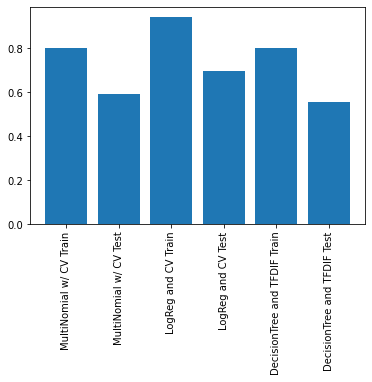

In [56]:
#Models out of Pipeline Function 

plt.bar(range(len(model_scores_1)), list(model_scores_1.values()), align='center')
plt.xticks(range(len(model_scores_1)), list(model_scores_1.keys()), rotation = 'vertical');


In [57]:
model_dict_1 = pd.DataFrame.from_dict(model_scores_1, orient='index')
model_dict_1

,0
MultiNomial w/ CV Train,0.799556
MultiNomial w/ CV Test,0.590667
LogReg and CV Train,0.940889
LogReg and CV Test,0.696000
DecisionTree and TFDIF Train,0.799556
DecisionTree and TFDIF Test,0.556000


In [58]:
#Models in Pipeline Function (first time ran)

df_scores = pd.DataFrame(model_scores)
df_scores.sort_values(ascending=False, by='test_score',axis=1)

df_scores = df_scores.T
df_scores

,vectorizer,model,features,train_score,test_score,best_params,y_test_hat
1,cv,svc,[],0.663556,0.682667,"{'cv__max_df': 1.0, 'cv__max_features': 5000, ...","[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, ..."
2,cv,knn,[],0.514222,0.504,"{'cv__max_df': 1.0, 'cv__max_features': 5000, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,cv,rf,[],0.666222,0.690667,"{'cv__max_df': 0.95, 'cv__max_features': 8000,...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ..."
4,cv,ab,[],0.665333,0.644,"{'ab__n_estimators': 125, 'cv__max_df': 1.0, '...","[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ..."
5,tv,svc,[],0.701333,0.714667,"{'svc__kernel': 'linear', 'tv__max_df': 1.0, '...","[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ..."
6,tv,knn,[],0.550667,0.513333,"{'knn__n_neighbors': 45, 'tv__max_df': 1.0, 't...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ..."
7,tv,rf,[],0.681333,0.654667,"{'rf__n_estimators': 8, 'tv__max_df': 0.95, 't...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ..."
8,tv,ab,[],0.656444,0.648,"{'ab__n_estimators': 125, 'tv__max_df': 0.95, ...","[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ..."


In [66]:
#Models in pipeline (2nd time ran)

df_scores_2 = pd.DataFrame(model_scores_2)
df_scores_2.sort_values(ascending=False, by='test_score',axis=1)

df_scores_2 = df_scores_2.T
df_scores_2

,vectorizer,model,features,train_score,test_score,best_params,y_test_hat
1,cv,lr,[],0.692889,0.696,"{'cv__max_df': 1.0, 'cv__max_features': 8000, ...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ..."
2,cv,bnb,[],0.663556,0.670667,"{'bnb__alpha': 1.0, 'cv__max_df': 1.0, 'cv__ma...","[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ..."
3,cv,mnb,[],0.68,0.684,"{'cv__max_df': 1.0, 'cv__max_features': 8000, ...","[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ..."
4,tv,lr,[],0.694222,0.692,"{'lr__C': 1, 'lr__penalty': 'l2', 'tv__max_df'...","[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ..."
5,tv,bnb,[],0.667111,0.672,"{'bnb__alpha': 1.0, 'tv__max_df': 1.0, 'tv__ma...","[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ..."
6,tv,mnb,[],0.676444,0.681333,"{'mnb__alpha': 1.2, 'tv__max_df': 1.0, 'tv__ma...","[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ..."


In [68]:
# All models ran in pipeline
df_scores_combined = pd.concat([df_scores, df_scores_2])

df_scores_combined

,vectorizer,model,features,train_score,test_score,best_params,y_test_hat,model_vect
1,cv,svc,[],0.663556,0.682667,"{'cv__max_df': 1.0, 'cv__max_features': 5000, ...","[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, ...",svc cv
2,cv,knn,[],0.514222,0.504,"{'cv__max_df': 1.0, 'cv__max_features': 5000, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",knn cv
3,cv,rf,[],0.666222,0.690667,"{'cv__max_df': 0.95, 'cv__max_features': 8000,...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...",rf cv
4,cv,ab,[],0.665333,0.644,"{'ab__n_estimators': 125, 'cv__max_df': 1.0, '...","[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...",ab cv
5,tv,svc,[],0.701333,0.714667,"{'svc__kernel': 'linear', 'tv__max_df': 1.0, '...","[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ...",svc tv
6,tv,knn,[],0.550667,0.513333,"{'knn__n_neighbors': 45, 'tv__max_df': 1.0, 't...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",knn tv
7,tv,rf,[],0.681333,0.654667,"{'rf__n_estimators': 8, 'tv__max_df': 0.95, 't...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...",rf tv
8,tv,ab,[],0.656444,0.648,"{'ab__n_estimators': 125, 'tv__max_df': 0.95, ...","[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...",ab tv
1,cv,lr,[],0.692889,0.696,"{'cv__max_df': 1.0, 'cv__max_features': 8000, ...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ...",NaN
2,cv,bnb,[],0.663556,0.670667,"{'bnb__alpha': 1.0, 'cv__max_df': 1.0, 'cv__ma...","[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...",NaN


In [59]:
df_scores_combined['model_vect'] = df_scores['model'] + ' '  + df_scores['vectorizer']

In [60]:
df_scores_combined.head()

,vectorizer,model,features,train_score,test_score,best_params,y_test_hat,model_vect
1,cv,svc,[],0.663556,0.682667,"{'cv__max_df': 1.0, 'cv__max_features': 5000, ...","[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, ...",svc cv
2,cv,knn,[],0.514222,0.504,"{'cv__max_df': 1.0, 'cv__max_features': 5000, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",knn cv
3,cv,rf,[],0.666222,0.690667,"{'cv__max_df': 0.95, 'cv__max_features': 8000,...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...",rf cv
4,cv,ab,[],0.665333,0.644,"{'ab__n_estimators': 125, 'cv__max_df': 1.0, '...","[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...",ab cv
5,tv,svc,[],0.701333,0.714667,"{'svc__kernel': 'linear', 'tv__max_df': 1.0, '...","[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, ...",svc tv
6,tv,knn,[],0.550667,0.513333,"{'knn__n_neighbors': 45, 'tv__max_df': 1.0, 't...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",knn tv
7,tv,rf,[],0.681333,0.654667,"{'rf__n_estimators': 8, 'tv__max_df': 0.95, 't...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...",rf tv
8,tv,ab,[],0.656444,0.648,"{'ab__n_estimators': 125, 'tv__max_df': 0.95, ...","[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...",ab tv


Text(0.5, 1.0, 'Test Scores')

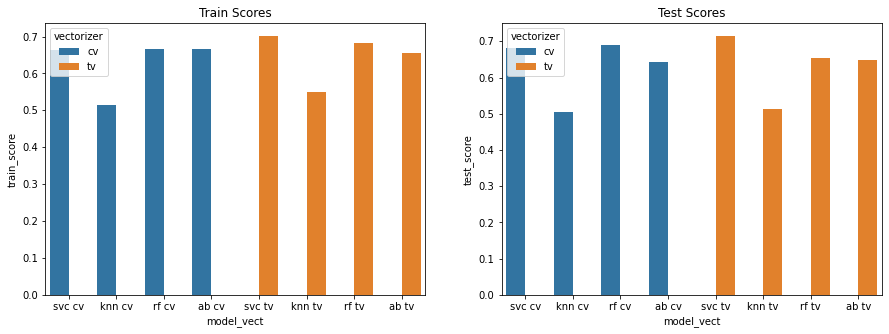

In [61]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(ax=axes[0],x="model_vect", y="train_score", hue="vectorizer", data=df_scores).set_title('Train Scores')
sns.barplot(ax=axes[1],x="model_vect", y="test_score", hue="vectorizer", data=df_scores).set_title('Test Scores')

## Feature Importance

Feature: 0, Score: -0.26894
Feature: 1, Score: -0.17824
Feature: 2, Score: 0.18000
Feature: 3, Score: -0.24269
Feature: 4, Score: -0.19038
Feature: 5, Score: -0.34936
Feature: 6, Score: -0.34936
Feature: 7, Score: 0.32593
Feature: 8, Score: 0.32593
Feature: 9, Score: 0.18000
Feature: 10, Score: 0.18000
Feature: 11, Score: -0.24269
Feature: 12, Score: 0.10755
Feature: 13, Score: -0.34936
Feature: 14, Score: -0.24269
Feature: 15, Score: 0.16873
Feature: 16, Score: 0.20904
Feature: 17, Score: -0.15061
Feature: 18, Score: 0.20904
Feature: 19, Score: 0.16873
Feature: 20, Score: 0.20904
Feature: 21, Score: 0.13633
Feature: 22, Score: 0.28366
Feature: 23, Score: -0.13126
Feature: 24, Score: 0.32593
Feature: 25, Score: -0.24269
Feature: 26, Score: -0.26894
Feature: 27, Score: -0.26894
Feature: 28, Score: -0.15061
Feature: 29, Score: -0.34936
Feature: 30, Score: -0.17824
Feature: 31, Score: -0.17824
Feature: 32, Score: 0.20904
Feature: 33, Score: 0.18000
Feature: 34, Score: -0.15061
Feature: 35

Feature: 1674, Score: 0.25243
Feature: 1675, Score: 0.19323
Feature: 1676, Score: -0.34936
Feature: 1677, Score: -0.22178
Feature: 1678, Score: -0.15061
Feature: 1679, Score: 0.18000
Feature: 1680, Score: -0.26894
Feature: 1681, Score: -0.19038
Feature: 1682, Score: -0.24269
Feature: 1683, Score: -0.19038
Feature: 1684, Score: -0.34936
Feature: 1685, Score: -0.15061
Feature: 1686, Score: -0.41564
Feature: 1687, Score: 0.32593
Feature: 1688, Score: 0.22831
Feature: 1689, Score: 0.38637
Feature: 1690, Score: 0.32593
Feature: 1691, Score: 0.22831
Feature: 1692, Score: -0.34936
Feature: 1693, Score: -0.30304
Feature: 1694, Score: 0.38637
Feature: 1695, Score: -0.19038
Feature: 1696, Score: 0.25243
Feature: 1697, Score: 0.13633
Feature: 1698, Score: -0.30304
Feature: 1699, Score: -0.26894
Feature: 1700, Score: 0.38637
Feature: 1701, Score: -0.26894
Feature: 1702, Score: -0.26894
Feature: 1703, Score: -0.15061
Feature: 1704, Score: -0.19038
Feature: 1705, Score: -0.34936
Feature: 1706, Score

Feature: 2673, Score: 0.20904
Feature: 2674, Score: -0.34936
Feature: 2675, Score: 0.38637
Feature: 2676, Score: 0.32593
Feature: 2677, Score: -0.41564
Feature: 2678, Score: 0.32593
Feature: 2679, Score: -0.30304
Feature: 2680, Score: -0.41564
Feature: 2681, Score: -0.15865
Feature: 2682, Score: -0.30304
Feature: 2683, Score: 0.38637
Feature: 2684, Score: -0.24269
Feature: 2685, Score: 0.15900
Feature: 2686, Score: -0.41564
Feature: 2687, Score: -0.34936
Feature: 2688, Score: 0.32593
Feature: 2689, Score: -0.41564
Feature: 2690, Score: 0.19323
Feature: 2691, Score: -0.20467
Feature: 2692, Score: -0.20467
Feature: 2693, Score: -0.19038
Feature: 2694, Score: -0.34936
Feature: 2695, Score: -0.34936
Feature: 2696, Score: 0.25243
Feature: 2697, Score: 0.28366
Feature: 2698, Score: -0.19038
Feature: 2699, Score: -0.30304
Feature: 2700, Score: -0.34936
Feature: 2701, Score: -0.24269
Feature: 2702, Score: -0.30304
Feature: 2703, Score: 0.18000
Feature: 2704, Score: 0.15900
Feature: 2705, Score

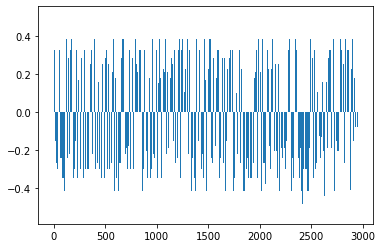

In [62]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X = X_train_cvec
y = y_train
#= make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance);
pyplot.show();

# Model Misclassifications

In [63]:
# Average the y_test_hat vectors to see if we can improve the score
y_test_hat_agg = sum(df_scores['y_test_hat'])
y_test_hat = np.round(y_test_hat_agg/df_scores.shape[1])
print("The accuracy score of the average test solutions is {:.2f}%.".format(accuracy_score(y_test,y_test_hat)*100))




The accuracy score of the average test solutions is 69.60%.


In [64]:
X_test['y'] = y_test.values
X_test['y_hat'] = y_test_hat
X_test['y_hat_agg'] = y_test_hat_agg

In [65]:
X_test_incorrect = X_test[X_test["y"] != X_test['y_hat']]
X_test_incorrect.head(20)

,title,y,y_hat,y_hat_agg
1190,Thus Woman in Twitter....,0,1.0,5
1411,This dude is a god :O ingenious Spanish writer...,0,1.0,7
644,The Gladiators - Pretenting 12' - A bit of gre...,0,1.0,6
1763,The male in question groomed multiple young wo...,1,0.0,2
1226,Like actually wtf is this. (Found in r/cringet...,0,1.0,6
296,"this post with nearly 175,000 likes on instagr...",0,1.0,7
1665,Gotta love those empty threats. And the consis...,1,0.0,3
746,Acting Homeland Security Secretary Chad Wolf T...,0,1.0,7
291,Rant. Insert attention-grabbing headline here.,0,1.0,5
781,Trump has been banned from social media. If on...,0,1.0,6


#  Executive summary
### The data
For this project, I chose two sub-reddits to compare, r/Feminists  and r/MensRights. 

### Exploring the data
Once I had scraped the data, I ran a number of initial tests on it to get some insight. I used a word cloud to illustrate the word used most often in each subreddit. I then ran a vectorizer on unigrams and made some bar charts comparing the usage of the most words. Even in the top words of titles it provides insight into the communties, as some of the top words for Mensrights were "Accused", "Women", and "Rape".

### Modeling the problem
I explored a range of models and hypertuned the parameters countless times in combination with the use different vectorizers such as Count Vectorizer and TFIDF.


### Evaluate the model
The models were either overfit, and performing badly or non over and still performing poorly. The baseline accuracy for my model was 50%, my best test and train score both sat at around 70% and were attained using a simple Count Vectorizer and Logistic Regression. After examining the misclassifications it appears that many of these errors are because title's aren't giving specific enough information for our model to classify.